In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
a = np.arange(3)
a[1:]

array([1, 2])

In [6]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
19
up [[36], [35], [38], [27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85], [42], [44, 54, 68, 69, 70, 71, 73, 78, 80], [46], [67, 72, 74, 79, 81], [45], [29, 41, 61, 64, 84], [48], [47, 60, 63, 77, 86, 87], [50], [30, 43, 62, 76, 83], [49], [55, 57, 58], [51], [52, 53, 59, 82]]
 [INFO] : 
 |  True
36
36
36
75
75
75
42
42
42
42
42
42
44
44
44
38
38
38
42
42
42
42
42
42
36
36
36
42
42
42
42
42
42
44
44
44
38
38
38
42
42
42
42
42
42
36
36
36
36
75
75
75
51
51
51
51
51
51
44
44
44
38
38
38
51
51
51
51
51
51
36
36
36
51
51
51
51
51
51
38
38
38
44
44
44
51
51
51
51
51
51
36
36
36
75
75
75
74
74
74
74
74
74
74
74
74
44
44
44
74
74
74
32
32
32
74
74
74
43
43
43
32
32
32
30
30
30
74
74
74
36
36
36
74
74
74
44
44
44
39
39
39
47
47
47
30
30
30
40
40
40
47
47
47
36
36
36
75
75
75
51
51
51
51
51
51
44
44
44
38
38
38
51
51
51
51
51
51
36
36
36
51
51
51
51
51
51
44
44
44
38
38
38
51
51
51
38
38
38
51
51
51
36
36
36

31
31
43
43
43
36
36
36
30
30
30
31
31
31
34
34
34
41
41
41
44
44
44
64
64
64
31
31
31
43
43
43
36
36
36
41
41
41
36
36
36
41
41
41
46
46
46
46
46
46
40
40
40
46
46
46
36
36
36
46
46
46
36
36
36
46
46
46
46
46
46
40
40
40
46
46
46
36
36
36
46
46
46
36
36
36
41
41
41
53
53
53
53
53
53
40
40
40
53
53
53
36
36
36
53
53
53
36
36
36
53
53
53
53
53
53
40
40
40
53
53
53
36
36
36
53
53
53
36
36
36
41
41
41
55
55
55
55
55
55
40
40
40
55
55
55
36
36
36
55
55
55
36
36
36
55
55
55
55
55
55
40
40
40
55
55
55
36
36
36
55
55
55
36
36
36
41
41
41
43
43
43
40
40
40
43
43
43
36
36
36
43
43
43
36
36
36
43
43
43
43
43
43
40
40
40
43
43
43
36
36
36
43
43
43
36
36
36
55
55
55
43
43
43
40
40
40
43
43
43
36
36
36
43
43
43
36
36
36
43
43
43
43
43
43
40
40
40
43
43
43
36
36
36
43
43
43
36
36
36
55
55
55
43
43
43
40
40
40
34
34
34
43
43
43
34
34
34
36
36
36
43
43
43
36
36
36
43
43
43
43
43
43
40
40
40
34
34
34
43
43
43
36
36
36
43
43
43
36
36
36
55
55
55
43
43
43
40
40
40
34
34
34
43
43
43
34
34
34
36
36
36
43
4

36
36
73
73
73
74
74
74
31
31
31
73
73
73
31
31
31
32
32
32
33
33
33
37
37
37
73
73
73
33
33
33
37
37
37
73
73
73
31
31
31
36
36
36
73
73
73
73
73
73
31
31
31
74
74
74
32
32
32
34
34
34
37
37
37
73
73
73
73
73
73
31
31
31
36
36
36
51
51
51
51
51
51
38
38
38
52
52
52
38
38
38
51
51
51
36
36
36
51
51
51
51
51
51
38
38
38
55
55
55
51
51
51
36
36
36
42
42
42
36
36
36
42
42
42
38
38
38
38
38
38
42
42
42
36
36
36
36
36
36
38
38
38
42
42
42
36
36
36
42
42
42
42
42
42
36
36
36
42
42
42
38
38
38
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
36
36
36
38
38
38
46
46
46
36
36
36
51
51
51
51
51
51
36
36
36
51
51
51
51
51
51
38
38
38
51
51
51
39
39
39
51
51
51
51
51
51
36
36
36
51
51
51
36
36
36
51
51
51
38
38
38
51
51
51
36
36
36
51
51
51
51
51
51
36
36
36
51
51
51
52
52
52
38
38
38
51
51
51
39
39
39
51
51
51
51
51
51
36
36
36
51
51
51
36
36
36
51
51
51
38
38
38
52
52
52
36
36
36
72
72
72
72
72
72
36
36
36
72
72
72
72
72
72
37
37
37
72
72
72
37
37
37
72
72
72
72
72
72
36
36
36
72
72
72
36
36
36
72
7

35
36
36
36
42
42
42
33
33
33
37
37
37
46
46
46
35
35
35
42
42
42
36
36
36
35
35
35
42
42
42
34
34
34
37
37
37
35
35
35
42
42
42
35
35
35
42
42
42
35
35
35
42
42
42
33
33
33
37
37
37
35
35
35
42
42
42
36
36
36
35
35
35
42
42
42
34
34
34
35
35
35
37
37
37
42
42
42
35
35
35
42
42
42
46
46
46
35
35
35
36
36
36
74
74
74
33
33
33
37
37
37
74
74
74
35
35
35
74
74
74
36
36
36
35
35
35
74
74
74
34
34
34
37
37
37
35
35
35
74
74
74
35
35
35
74
74
74
35
35
35
74
74
74
72
72
72
33
33
33
37
37
37
35
35
35
74
74
74
40
40
40
38
38
38
36
36
36
40
40
40
35
35
35
74
74
74
34
34
34
35
35
35
37
37
37
38
38
38
74
74
74
40
40
40
35
35
35
74
74
74
38
38
38
74
74
74
35
35
35
36
36
36
41
41
41
33
33
33
37
37
37
41
41
41
35
35
35
41
41
41
36
36
36
35
35
35
41
41
41
34
34
34
37
37
37
35
35
35
41
41
41
35
35
35
41
41
41
35
35
35
41
41
41
41
41
41
33
33
33
37
37
37
35
35
35
41
41
41
39
39
39
38
38
38
36
36
36
39
39
39
35
35
35
41
41
41
34
34
34
35
35
35
37
37
37
38
38
38
41
41
41
39
39
39
35
35
35
41
41
41
38
38
3

40
40
38
38
38
40
40
40
36
36
36
40
40
40
38
38
38
40
40
44
44
44
36
36
36
39
39
39
40
40
40
44
44
44
39
39
39
36
36
36
44
44
44
40
40
40
39
39
39
44
44
44
40
40
40
36
36
36
44
44
44
40
40
40
39
39
39
44
44
44
40
40
40
36
36
36
44
44
44
40
40
40
44
44
44
39
39
39
40
40
44
44
44
36
36
36
43
43
43
41
41
41
44
44
44
43
43
43
36
36
36
44
44
44
41
41
41
43
43
43
44
44
44
41
41
41
36
36
36
44
44
44
41
41
41
43
43
43
44
44
44
41
41
41
36
36
36
44
44
44
41
41
41
44
44
44
43
43
43
41
41
44
44
44
36
36
36
43
43
43
39
39
39
44
44
44
50
50
50
36
36
36
43
43
43
36
36
36
44
44
44
41
41
41
43
43
43
44
44
44
50
50
50
39
39
39
36
36
36
44
44
44
41
41
41
43
43
43
44
44
44
50
50
50
36
36
36
41
41
41
36
36
36
44
44
44
39
39
39
44
44
44
50
50
50
43
43
43
41
41
44
44
44
36
36
36
73
73
73
37
37
37
36
36
36
73
73
73
36
36
36
44
44
44
72
72
72
73
73
73
37
37
37
36
36
36
44
44
44
72
72
72
73
73
73
36
36
36
72
72
72
36
36
36
44
44
44
37
37
37
73
73
73
72
72
36
36
36
73
73
73
39
39
39
44
44
44
36
36
36
73
73
73
3

36
36
36
83
83
83
86
86
86
84
84
84
36
36
36
81
81
81
83
83
83
36
36
36
83
83
83
86
86
86
84
84
84
36
36
36
81
81
81
83
83
83
86
86
86
36
36
36
66
66
66
66
66
66
36
36
36
38
38
38
66
66
66
66
66
66
36
36
36
66
66
66
66
66
66
36
36
36
38
38
38
66
66
66
66
66
66
51
51
51
36
36
36
51
51
51
36
36
36
40
40
40
44
44
44
51
51
51
44
44
44
40
40
40
51
51
51
36
36
36
51
51
51
40
40
40
51
51
51
47
47
47
36
36
36
44
44
44
51
51
51
40
40
40
51
51
51
36
36
36
51
51
51
43
43
43
44
44
44
36
36
36
37
37
37
51
51
51
44
44
44
51
51
51
36
36
36
43
43
43
51
51
51
44
44
44
36
36
36
37
37
37
51
51
51
44
44
44
51
51
51
36
36
36
51
51
51
44
44
44
36
36
36
37
37
37
51
51
51
44
44
44
51
51
51
36
36
36
51
51
51
44
44
44
36
36
36
43
43
43
37
37
37
51
51
51
44
44
44
47
47
47
36
36
36
47
47
47
47
47
47
44
44
44
36
36
36
64
64
64
47
47
47
47
47
47
36
36
36
47
47
47
47
47
47
44
44
44
36
36
36
64
64
64
47
47
47
47
47
47
82
82
82
84
84
84
86
86
86
44
44
44
84
84
84
84
84
84
82
82
82
84
84
84
82
82
82
86
86
86
44
44
44
8

36
36
36
36
36
36
42
42
42
36
36
36
44
44
44
38
38
38
38
38
36
36
36
47
47
47
47
47
47
36
36
36
38
38
38
47
47
47
36
36
36
47
47
47
47
47
47
36
36
36
36
36
36
47
47
47
38
38
38
36
36
36
43
43
43
43
43
36
36
36
47
47
47
36
36
36
38
38
38
47
47
47
36
36
36
42
42
42
42
42
42
36
36
36
36
36
36
47
47
47
38
38
38
36
36
36
43
43
43
43
43
36
36
36
42
42
42
42
42
42
36
36
36
38
38
38
42
42
42
38
38
38
38
38
38
36
36
36
47
47
47
47
47
47
36
36
36
42
42
42
38
38
38
36
36
36
43
43
43
43
43
43
36
36
36
36
36
38
38
38
43
43
43
47
47
47
36
36
36
43
43
43
47
47
47
36
36
36
38
38
38
36
36
36
42
42
42
42
42
42
36
36
36
42
42
42
44
44
44
36
36
36
38
38
38
36
36
36
47
47
47
36
36
42
42
36
36
36
58
58
58
36
36
36
38
38
38
42
42
42
42
42
42
36
36
36
38
38
38
47
47
47
47
47
47
36
36
36
38
38
38
42
42
42
36
36
36
46
46
36
36
36
42
42
42
38
38
38
38
38
38
36
36
36
38
38
38
42
42
42
38
38
38
36
36
36
42
42
42
47
47
47
47
47
47
36
36
36
36
36
36
38
38
38
36
36
36
43
43
43
43
43
36
36
36
42
42
42
43
43
43
36
36
3

45
45
45
45
45
45
36
36
36
41
41
41
38
38
38
41
41
41
78
78
78
36
36
36
41
41
41
44
44
44
78
78
78
38
38
38
41
41
41
44
44
44
78
78
78
36
36
36
42
42
42
42
42
42
42
42
42
42
42
42
38
38
38
42
42
42
42
42
42
38
38
38
36
36
36
42
42
42
42
42
42
36
36
36
42
42
42
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
42
42
42
36
36
36
41
41
41
38
38
38
44
44
44
45
45
45
36
36
36
41
41
41
36
36
36
41
41
41
38
38
38
44
44
44
45
45
45
36
36
36
51
51
51
51
51
51
38
38
38
44
44
44
51
51
51
51
51
51
38
38
38
36
36
36
51
51
51
36
36
36
51
51
51
38
38
38
44
44
44
51
51
51
36
36
36
51
51
51
36
36
36
41
41
41
45
45
45
44
44
44
36
36
36
36
36
36
41
41
41
44
44
44
36
36
36
36
36
36
42
42
42
42
42
42
42
42
42
36
36
36
42
42
42
38
38
38
42
42
42
42
42
42
36
36
36
42
42
42
42
42
42
42
42
42
36
36
36
42
42
42
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
42
42
42
36
36
36
51
51
51
51
51
51
51
51
51
38
38
38
44
44
44
51
51
51
51
51
51
51
51
51
36
36
36
51
51
51
51
51
51
36
36
36
51
51
51
38
38
38
51
51
51
44
44
44
5

38
38
38
42
42
42
44
44
44
42
42
42
36
36
36
38
38
38
42
42
42
42
42
42
36
36
36
38
38
38
42
42
42
42
42
42
36
36
36
38
38
38
42
42
42
38
38
38
78
78
78
36
36
36
42
42
42
42
42
42
42
42
42
42
42
42
38
38
38
42
42
42
42
42
42
36
36
36
42
42
42
36
36
36
42
42
42
42
42
42
42
42
42
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
42
42
42
36
36
36
41
41
41
41
41
41
44
44
44
41
41
41
45
45
45
41
41
41
36
36
36
36
36
36
41
41
41
41
41
41
38
38
38
41
41
41
44
44
44
36
36
36
41
41
41
36
36
36
41
41
41
44
44
44
41
41
41
38
38
38
41
41
41
61
61
61
36
36
36
41
41
41
36
36
36
41
41
41
41
41
41
38
38
38
41
41
41
44
44
44
36
36
36
41
41
41
36
36
36
44
44
44
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
38
38
38
42
42
42
42
42
42
36
36
36
42
42
42
42
42
42
38
38
38
42
42
42
42
42
42
38
38
38
36
36
36
42
42
42
36
36
36
42
42
42
38
38
38
42
42
42
42
42
42
36
36
36
38
38
38
42
42
42
42
42
42
42
42
42
38
38
38
42
42
42
38
38
38
42
42
42
42
42
42
38
38
38
42
42
42
36
36
36
42
42
42
36
36
36
42
42
42
42
42
42
4

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [8]:
x_train.shape

(500, 40, 7, 1)

In [9]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 7, 1), 450)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 7)


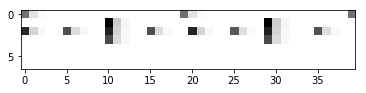

m (40, 7)


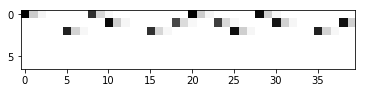

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U106')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 7, 1)

In [13]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [14]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)
    timesteps, notes, channels = input_shape
    
    # Convolution
    h = encoder_input
    k = (2,1)
    s = (2,1)
    
    h = Reshape((timesteps, notes))(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    
    h = Bidirectional(LSTM(128))(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
#     print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])

    return encoder_model, encoder_input, z_mean, z_log_var

In [15]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 7, 1)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 40, 7)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39, 64)       960         reshape_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [16]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [17]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [18]:
def list_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape

    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(256) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
    # add a bypass layer
    w = 256
    decoders += [ Dense(w, activation='relu') ]
    extra_decoders = []
    for _ in range(3):
        extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

    extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
    decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
    decoders += [ BatchNormalization(momentum=0.5) ]

    n = 4
    dim1, dim2, filters = n, int(timesteps/n), 250
    decoders += [ Reshape((n, int(w/n))) ]
    decoders += [ TimeDistributed(Dense(filters, activation='relu')) ]
    print(n*w/timesteps, timesteps, filters, n, timesteps*n*w/timesteps)
#     decoders += [ Reshape((timesteps, int(n*filters/timesteps) )) ]
#     decoders += [ Reshape((int(timesteps * filters*n/timesteps),)) ]
    decoders += [ Reshape((timesteps, int(filters*n/timesteps),)) ]
#     decoders += [ Reshape((40, 256)) ]

    decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
    decoders += [ Reshape((timesteps, notes, 1)) ]

    return decoders

In [19]:
decoders = list_decoders(input_shape)

25.6 40 250 4 1024.0


In [20]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [21]:
# layer1.output

In [22]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 7, 1)     0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 199620      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          768         lambda_2[0][0]                   
__________

In [23]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Output "reshape_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_4" during training.
  from ipykernel import kernelapp as app


In [24]:
K.int_shape(z_mean)

(None, 2)

In [25]:
batch_size = 10
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [26]:
phase_mod = 0.01
whitening = False

In [ ]:
# m = 2
useDataGenerator = False
# useDataGenerator = True

x = x_train
i = [0,1, 7,8, 14,15, 399,400]
x_ = x_train[i]
x = np.concatenate([x_ for _ in range(50)])
print('x:', x.shape)

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (400, 40, 7, 1)
batch_size = 10
Train on 400 samples, validate on 50 samples
Epoch 1/100
400/400 [==============================] - 7s 16ms/step - loss: 166.8511 - val_loss: 143.2920
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 133.2045 - val_loss: 120.2037
Epoch 3/100
400/400 [==============================] - 2s 4ms/step - loss: 106.1264 - val_loss: 97.0902
Epoch 4/100
400/400 [==============================] - 2s 4ms/step - loss: 82.1695 - val_loss: 79.1004
Epoch 5/100
400/400 [==============================] - 2s 4ms/step - loss: 65.6293 - val_loss: 66.8528
Epoch 6/100
400/400 [==============================] - 1s 4ms/step - loss: 51.9375 - val_loss: 57.3222
Epoch 7/100
400/400 [==============================] - 1s 4ms/step - loss: 45.5575 - val_loss: 54.5247
Epoch 8/100
400/400 [==============================] - 1s 3ms/step - loss: 40.6387 - val_loss: 52.2924
Epoch 9/100
400/400 [==============================] - 1s 4ms/step - loss: 38.6738 - val_l

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [ ]:
x = x_train
x1 = x_train[0] # 0
x2 = x_train[399] # 399
x_ = [x1,x2] # x_train[:m]
x = np.concatenate([x_ for _ in range(100)])

In [ ]:
x.shape

In [ ]:
x_[0].shape

In [ ]:
i = 0
j = 9
y = vae.predict(x[:10])
plot.single(x[i, :50, :, 0])
plot.single(y[i, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(y[j, :50, :, 0])

In [ ]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [ ]:
x.shape

In [ ]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [ ]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [ ]:
x_test.shape

In [ ]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

In [ ]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [ ]:
# x_decoded[0].reshape(150,3)

In [ ]:
x_train.shape

In [ ]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

In [ ]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)